In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('house-prices.csv')

# Initial exploration
print(df.head())
print("\nDataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

   Home   Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
0     1  114300  1790         2          2       2    No         East
1     2  114200  2030         4          2       3    No         East
2     3  114800  1740         3          2       1    No         East
3     4   94700  1980         3          2       3    No         East
4     5  119800  2130         3          3       3    No         East

Dataset shape: (128, 8)

Data types:
 Home             int64
Price            int64
SqFt             int64
Bedrooms         int64
Bathrooms        int64
Offers           int64
Brick           object
Neighborhood    object
dtype: object

Missing values:
 Home            0
Price           0
SqFt            0
Bedrooms        0
Bathrooms       0
Offers          0
Brick           0
Neighborhood    0
dtype: int64


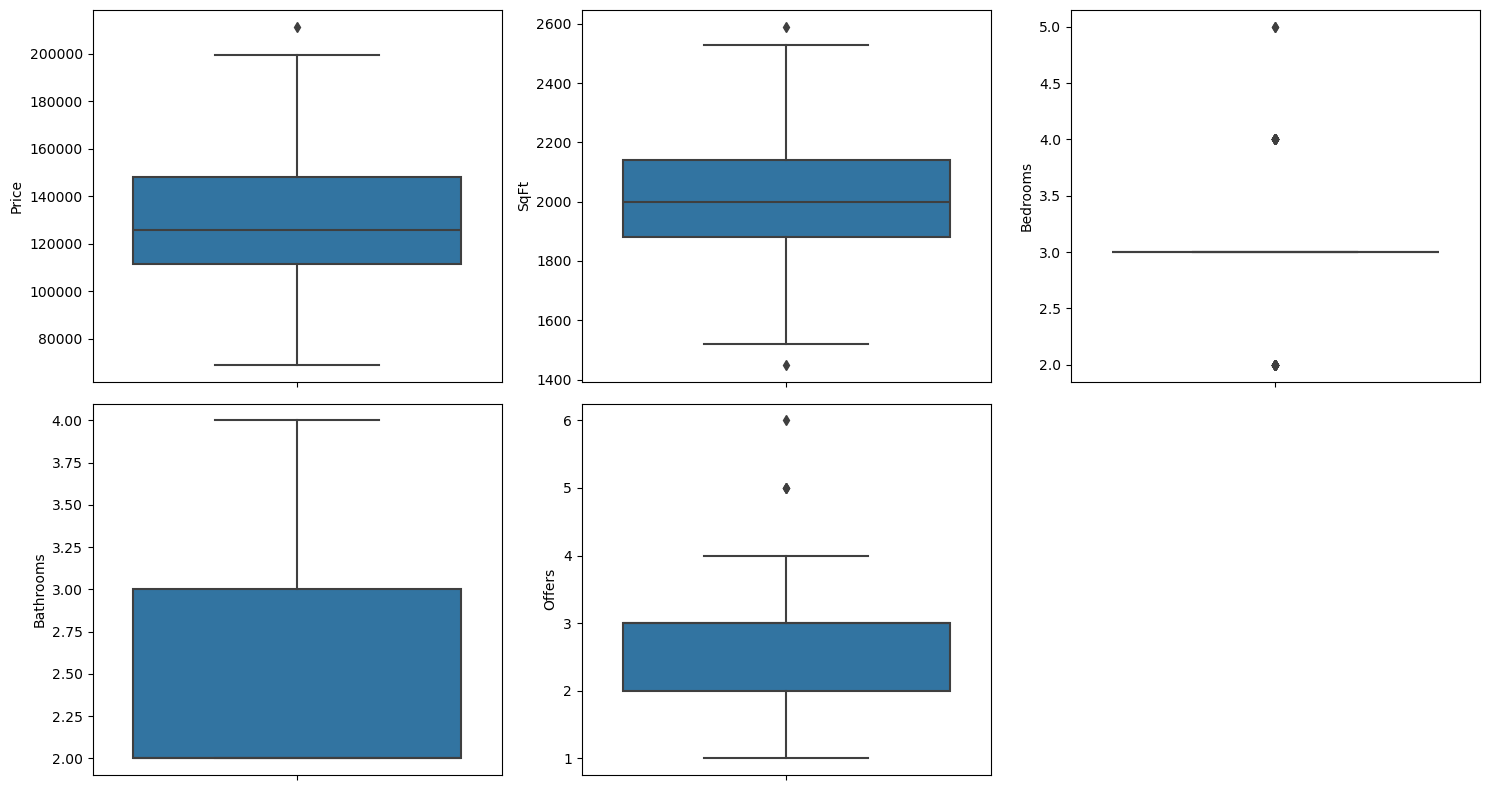

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

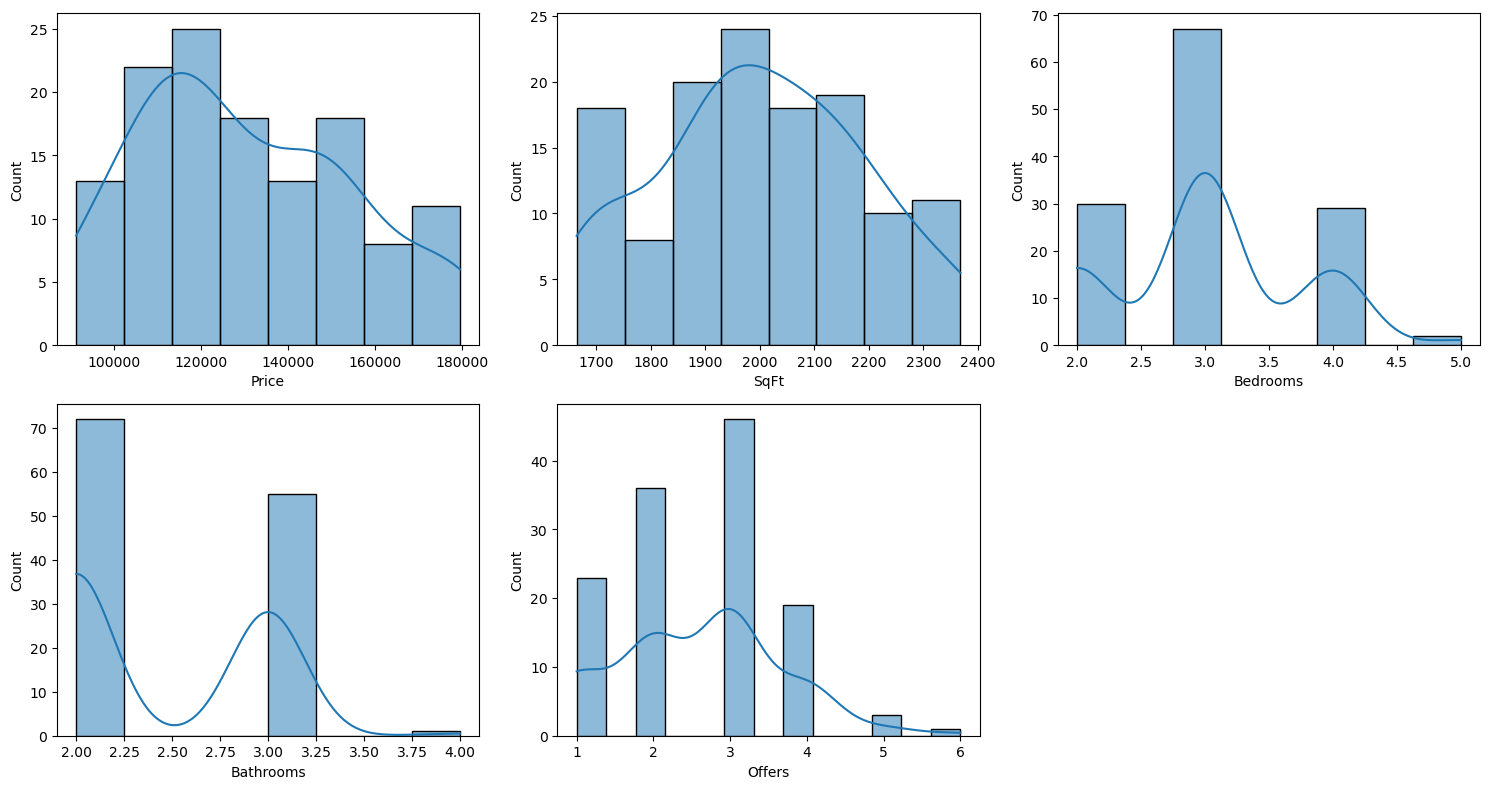

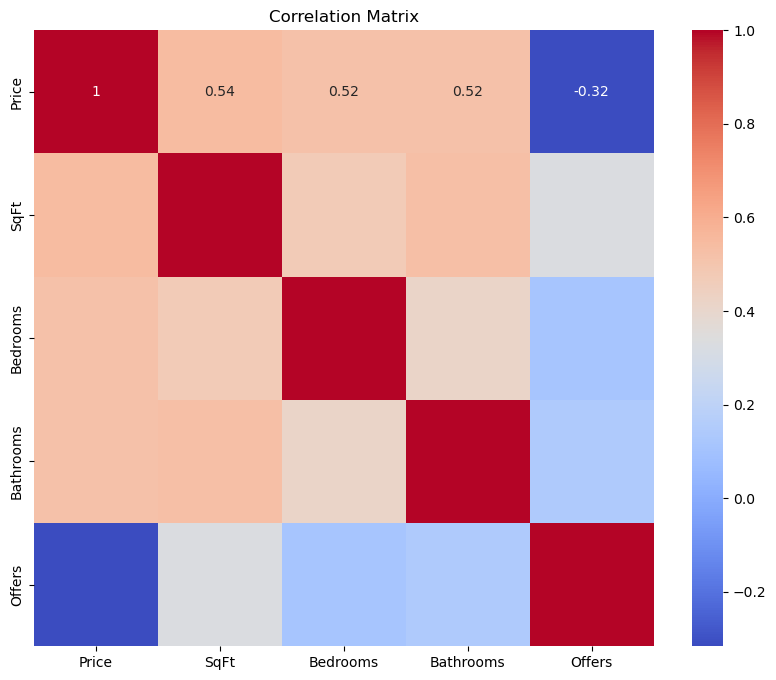

In [2]:
# Drop the 'Home' column as it's just an identifier
df = df.drop('Home', axis=1)

# Check for outliers
numeric_cols = ['Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=col)
plt.tight_layout()
plt.show()

# Handle outliers - we'll cap extreme values for SqFt and Price
df['SqFt'] = df['SqFt'].clip(lower=df['SqFt'].quantile(0.05), upper=df['SqFt'].quantile(0.95))
df['Price'] = df['Price'].clip(lower=df['Price'].quantile(0.05), upper=df['Price'].quantile(0.95))

# Visualize distributions
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [3]:
# Create preprocessing pipeline
numeric_features = ['SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
categorical_features = ['Brick', 'Neighborhood']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [4]:
# Split data into features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SqFt', 'Bedrooms',
                                                   'Bathrooms', 'Offers']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brick', 'Neighborhood'])])),
                ('regressor', LinearRegression())])

RMSE: 9310.75
R² Score: 0.8389


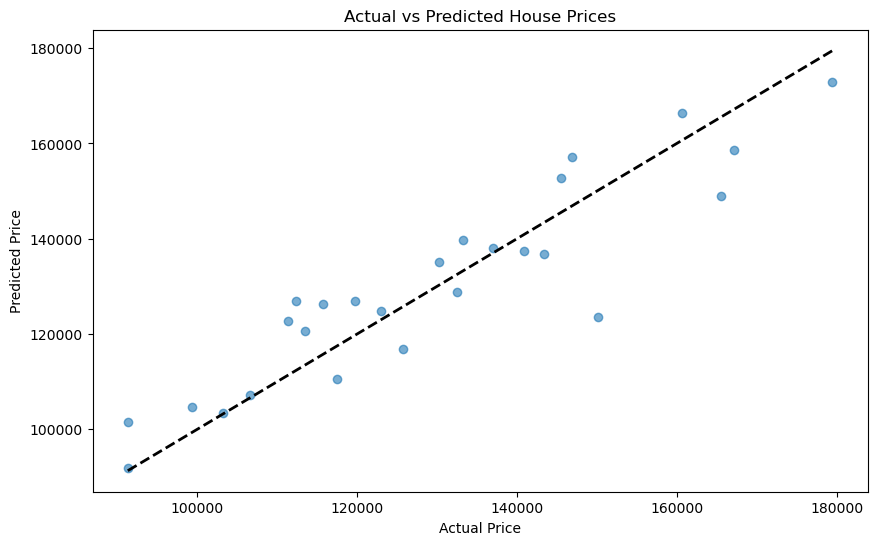

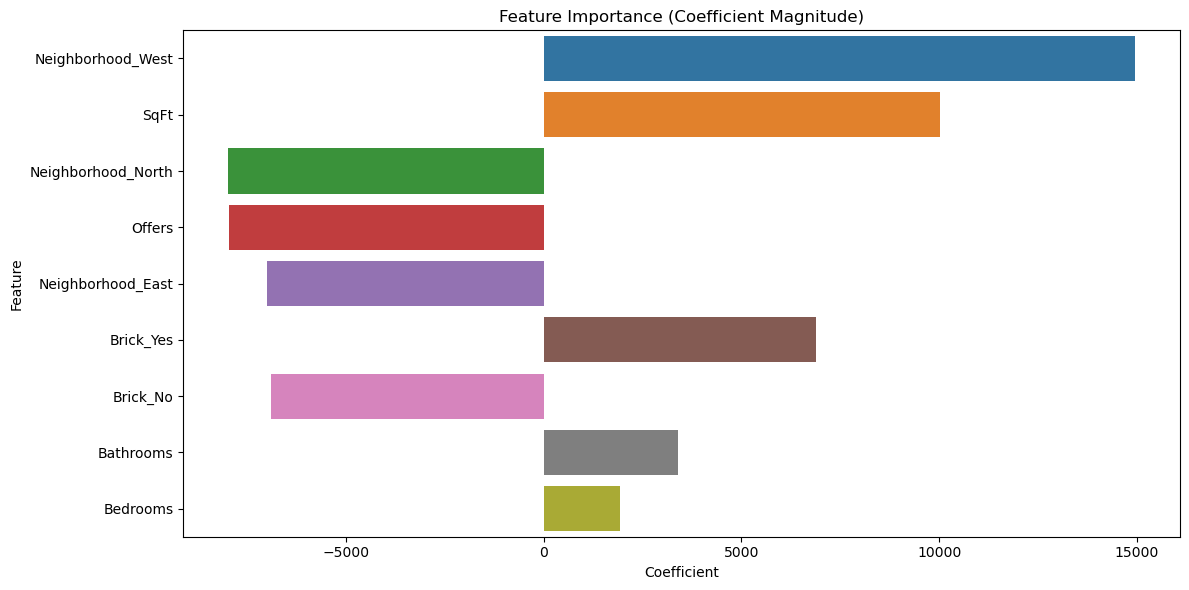

In [5]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.show()

# Feature importance
if hasattr(model.named_steps['regressor'], 'coef_'):
    # Get feature names after one-hot encoding
    ohe_categories = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
    feature_names = numeric_features + \
        [f'Brick_{val}' for val in ohe_categories[0]] + \
        [f'Neighborhood_{val}' for val in ohe_categories[1]]
    
    coefficients = model.named_steps['regressor'].coef_
    importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    importance = importance.sort_values(by='Coefficient', key=abs, ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance, x='Coefficient', y='Feature')
    plt.title('Feature Importance (Coefficient Magnitude)')
    plt.tight_layout()
    plt.show()